#  Previsão de Atraso de Voo
## Projeto de Aprendizagem Supervisionada

Este projeto tem como objetivo desenvolver um modelo preditivo capaz de identificar voos com alta taxa de atraso em aeroportos e companhias aéreas dos EUA, utilizando dados da indústria aérea.

### 1.1 Contexto do Problema

O setor de aviação é altamente sensível à pontualidade. Atrasos geram custos operacionais e insatisfação do cliente, logo há valor em conseguir prever atrasos.

### 1.2 Enquadramento da Solução

* **Tipo de Aprendizagem:** Aprendizagem Supervisionada.
* **Problema:** Classificação Binária.
* **Variável Alvo:** `is_high_delay_rate` (1: Alto Risco de Atraso, 0: Baixo Risco).

### 1.3 Perguntas de Negócio

1.  Quais Companhias Aéreas e Aeroportos contribuem mais para o alto risco de atraso?
2.  Existe sazonalidade (mês do ano) no risco de atraso?
3.  Quais são os preditores mais fortes de uma alta taxa de atraso?

### 1.4 Configuração do Ambiente e Instalação de Bibliotecas

In [2]:
# install das bibs necessarias (fora do collab tire o comentario)
# !pip install numpy pandas scikit-learn matplotlib seaborn xgboost lightgbm

# import das bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import xgboost as xgb
import lightgbm as lgb

### 2.1 Carregamento do Dataset

O dataset `Airline_Delay_Cause.csv` foi carregado diretamente no ambiente do Colab, mas pode-se utilizar outras plataformas, contanto que você tenha acesso ao dataset no diretório. A leitura é feita utilizando a biblioteca `pandas`.

In [3]:
FILE_NAME = 'Airline_Delay_Cause.csv'

try:
    # carregando arquivo
    df = pd.read_csv(FILE_NAME)
    print(f"Dataset '{FILE_NAME}' carregado com sucesso")
except FileNotFoundError:
    print(f"Erro: O arquivo '{FILE_NAME}' não foi encontrado")
    df = None

if df is not None:
    print("Primeiras 5 linhas")
    print(df.head())

Dataset 'Airline_Delay_Cause.csv' carregado com sucesso
Primeiras 5 linhas
   year  month carrier       carrier_name airport  \
0  2023      8      9E  Endeavor Air Inc.     ABE   
1  2023      8      9E  Endeavor Air Inc.     ABY   
2  2023      8      9E  Endeavor Air Inc.     AEX   
3  2023      8      9E  Endeavor Air Inc.     AGS   
4  2023      8      9E  Endeavor Air Inc.     ALB   

                                        airport_name  arr_flights  arr_del15  \
0  Allentown/Bethlehem/Easton, PA: Lehigh Valley ...         89.0       13.0   
1             Albany, GA: Southwest Georgia Regional         62.0       10.0   
2           Alexandria, LA: Alexandria International         62.0       10.0   
3        Augusta, GA: Augusta Regional at Bush Field         66.0       12.0   
4                   Albany, NY: Albany International         92.0       22.0   

   carrier_ct  weather_ct  ...  security_ct  late_aircraft_ct  arr_cancelled  \
0        2.25        1.60  ...          0.0  

### 2.2 Inspeção da Estrutura dos Dados

É fundamental verificar o número de registros, o tipo de dado de cada coluna e a existência de valores nulos (Nulls/NaNs) para planejar o pré-processamento.

In [4]:
if df is not None:
    print(f"O Dataset possui {df.shape[0]} linhas e {df.shape[1]} colunas.")

    print("Informacoes detalhadas:")
    df.info()

O Dataset possui 171666 linhas e 21 colunas.
Informacoes detalhadas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171666 entries, 0 to 171665
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   year                 171666 non-null  int64  
 1   month                171666 non-null  int64  
 2   carrier              171666 non-null  object 
 3   carrier_name         171666 non-null  object 
 4   airport              171666 non-null  object 
 5   airport_name         171666 non-null  object 
 6   arr_flights          171426 non-null  float64
 7   arr_del15            171223 non-null  float64
 8   carrier_ct           171426 non-null  float64
 9   weather_ct           171426 non-null  float64
 10  nas_ct               171426 non-null  float64
 11  security_ct          171426 non-null  float64
 12  late_aircraft_ct     171426 non-null  float64
 13  arr_cancelled        171426 non-null  float64
 14 

### 3.1 Criação da Variável Alvo (`is_high_delay_rate`)

Como o dataset é agregado, o problema é reformulado. Em vez de prever um voo em particular, prevemos se a Taxa de Atraso mensal de uma operação é elevada.

1.  **Limpeza:** Removemos registros onde `arr_flights` é zero (divisão por zero).
2.  **Taxa de Atraso:** Calculamos a proporção `arr_del15 / arr_flights`.
3.  **Variável Alvo:** Definimos **Alto Atraso (1)** como qualquer registro cuja `delay_rate` esteja **acima do 75º Percentil (Q3)** da distribuição geral. Isso garante um *target* razoavelmente balanceado para o modelo.

In [5]:
# remove-se linhas onde arr_flight é zero, já que nao representam operações válidas
print(f"Numero de registros pré-limpeza: {df.shape[0]}") # shape[0] = numero de linhas
df = df[df['arr_flights'] > 0].copy()
print(f"Número de registros apos limpeza: {df.shape[0]}")

# definiçao da feature principal do problema
df['delay_rate'] = df['arr_del15'] / df['arr_flights'] # voos atrasados por 15 ou mais minutos / total de voos

# alvo: taxa de atraso elevado
# define-se que se a taxa de atraso estiver no top 25% das piores taxas ela será considerada alto risco
# problema torna-se binario, ja que ou é alto risco ou não
threshold_delay_rate = df['delay_rate'].quantile(0.75)
print(f"Threshold para 'high_delay_rate': {threshold_delay_rate:.4f}")

# definicao da variavel alvo
df['is_high_delay_rate'] = (df['delay_rate'] > threshold_delay_rate).astype(int)

# verificando balanceamento da variavel alvo
target_distribution = df['is_high_delay_rate'].value_counts(normalize=True)
print("Distribuição da Variável Alvo 'is_high_delay_rate':")
print(target_distribution)

Numero de registros pré-limpeza: 171666
Número de registros apos limpeza: 171426
Threshold para 'high_delay_rate': 0.2415
Distribuição da Variável Alvo 'is_high_delay_rate':
is_high_delay_rate
0    0.750295
1    0.249705
Name: proportion, dtype: float64


### 3.2 Tratamento de Valores Ausentes (NaNs)

Os valores ausentes (NaNs) do dataset podem comprometer a sua integridade. Por isso, é conveniente tratá-los de forma apropriada.

1. Substituição por 0: colunas de contagem de eventos ou indicadores de ocorrência foram preenchidos com 0, já que ausencia do valor = não ocorrencia do evento.

2. As colunas de **arr_delay15** e de **delay_rate** não podem ser seguramente preenchidas com 0, então elas serão removidas, com um impacto mínimo ao dataset.

In [6]:
# buscando valores ausentes
nan_counts = df.isnull().sum()
nan_counts = nan_counts[nan_counts > 0].sort_values(ascending=False)

if not nan_counts.empty:
    # preenche-se os NaNs com 0, assumindo que valor ausente = sem contribuicao
    cols_to_fill_zero = [col for col in df.columns if any(suffix in col for suffix in ['_ct', '_delay', 'arr_cancelled', 'arr_diverted'])]

    df[cols_to_fill_zero] = df[cols_to_fill_zero].fillna(0)

    # removendo as linhas em que colunas essenciais continuam incompletas
    # as NaNs restantes estão em "arr_del15" e "delay_rate"
    linhas_antes = len(df)
    df.dropna(subset=['arr_del15', 'delay_rate'], inplace=True)
    linhas_depois = len(df)
    print(f"Removidas {linhas_antes - linhas_depois} linhas com NaNs restantes")

    # verificando de novo
    if df.isnull().sum().any():
        print("Colunas com NaNs restantes: ")
        print(df.isnull().sum()[df.isnull().sum() > 0])
    else:
        print("Sem mais NaNs no dataset")
else:
    print("Não haviam valores ausentes")

Removidas 203 linhas com NaNs restantes
Sem mais NaNs no dataset


### 3.3 Análise Exploratória de Dados (EDA)

#### EDA 1: Taxa de Atraso por Companhia Aérea

A análise da taxa média de atraso por companhia aérea é vital para identificar os principais *stakeholders* do problema. Companhias com maior taxa média representam um risco estrutural maior de atraso, o que as torna fortes preditores.

10 maiores taxas medias de atraso: 
carrier_name
JetBlue Airways                 0.234261
American Eagle Airlines Inc.    0.230182
Frontier Airlines Inc.          0.227271
American Airlines Inc.          0.210077
Allegiant Air                   0.207356
Southwest Airlines Co.          0.205420
ExpressJet Airlines Inc.        0.204493
Spirit Air Lines                0.203987
United Air Lines Inc.           0.198207
Hawaiian Airlines Inc.          0.194199


/tmp/ipython-input-2792410962.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_delay_by_carrier.head(10).index, y=avg_delay_by_carrier.head(10).values, palette="viridis")


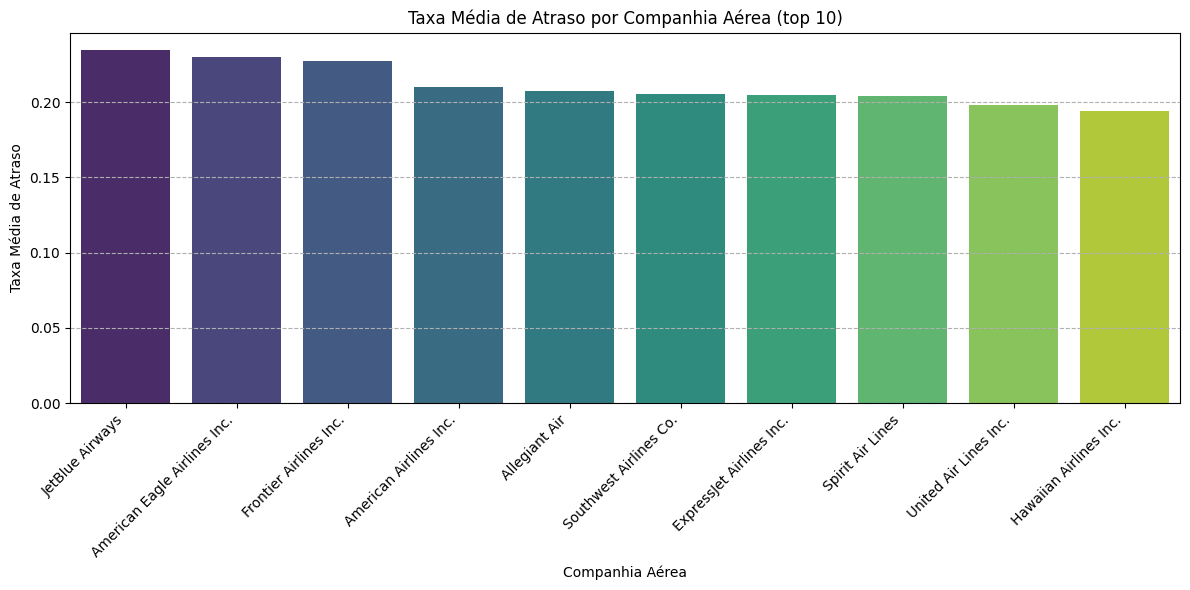

In [7]:
# agrupamento da taxa media de atraso por companhia aérea
avg_delay_by_carrier = df.groupby('carrier_name')['delay_rate'].mean().sort_values(ascending=False)

print("10 maiores taxas medias de atraso: ")
print(avg_delay_by_carrier.head(10).to_string())

# grafico de taxa de atraso por companhia
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_delay_by_carrier.head(10).index, y=avg_delay_by_carrier.head(10).values, palette="viridis")
plt.title('Taxa Média de Atraso por Companhia Aérea (top 10)')
plt.ylabel('Taxa Média de Atraso')
plt.xlabel('Companhia Aérea')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

#### EDA 2: Taxa de Atraso por Mês

A análise mensal verifica a sazonalidade. Geralmente, os atrasos aumentam nos meses de verão (congestão e clima) e nos meses de inverno (neve/gelo).

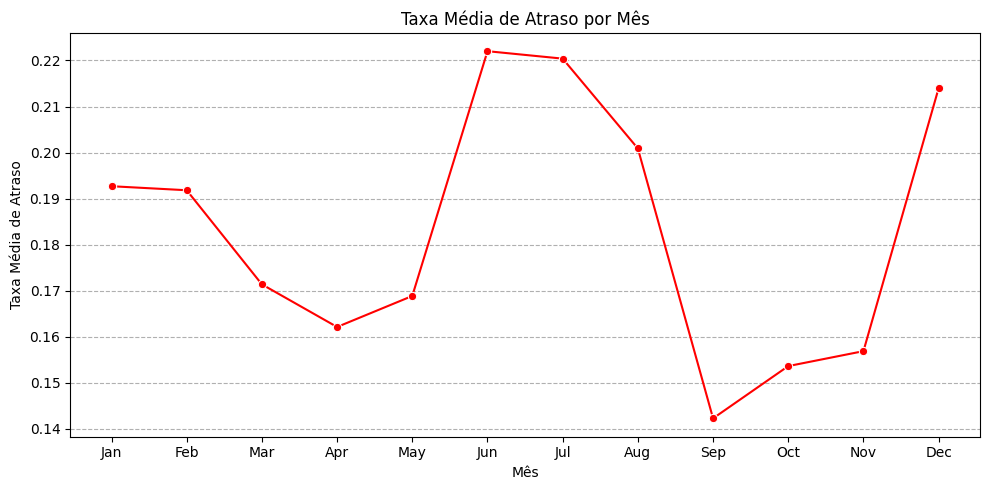

In [8]:
# agrupamento da taxa media de atraso por mes
avg_delay_by_month = df.groupby('month')['delay_rate'].mean()
avg_delay_by_month.index = avg_delay_by_month.index.map(lambda x: pd.to_datetime(x, format='%m').strftime('%b'))

# grafico de taxa de atraso media por mes
plt.figure(figsize=(10, 5))
sns.lineplot(x=avg_delay_by_month.index, y=avg_delay_by_month.values, marker='o', color='red')
plt.title('Taxa Média de Atraso por Mês')
plt.ylabel('Taxa Média de Atraso')
plt.xlabel('Mês')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

### 4.1 Seleção de Features e Combate ao Data Leakage

Para garantir a utilidade preditiva do modelo, é crucial evitar o **vazamento de dados (data leakage)**, que ocorre quando features que só são conhecidas *após* a ocorrência do evento (ex: `carrier_delay`, `arr_delay`) são usadas como preditoras.

Selecionamos apenas variáveis conhecidas **a priori**: `year`, `month`, `carrier_name` e `airport_name`.

In [9]:
# mantém-se apenas colunas conhecidas a priori (mes, ano, nomes)
# todas colunas de atraso por causa são vazamentos

# features
features = ['year', 'month', 'carrier_name', 'airport_name']

# target
TARGET = 'is_high_delay_rate'

# dataset final
X = df[features]
y = df[TARGET]

print("Features selecionadas (x):")
print(X.head())
print("Variavel alvo (y):", y.shape)

Features selecionadas (x):
   year  month       carrier_name  \
0  2023      8  Endeavor Air Inc.   
1  2023      8  Endeavor Air Inc.   
2  2023      8  Endeavor Air Inc.   
3  2023      8  Endeavor Air Inc.   
4  2023      8  Endeavor Air Inc.   

                                        airport_name  
0  Allentown/Bethlehem/Easton, PA: Lehigh Valley ...  
1             Albany, GA: Southwest Georgia Regional  
2           Alexandria, LA: Alexandria International  
3        Augusta, GA: Augusta Regional at Bush Field  
4                   Albany, NY: Albany International  
Variavel alvo (y): (171223,)


### 4.2 Divisão do Dataset (Treino e Teste)

O dataset é dividido em conjuntos de Treinamento (80%) e Teste (20%). Usamos a estratégia **`stratify=y`** para garantir que a proporção de observações de "Alto Atraso" seja igual em ambos os conjuntos, combatendo o potencial desbalanceamento.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y # mantém a proporção de var alvo p evitar vies
)

print(f"Shape do X_train: {X_train.shape}")
print(f"Shape do X_test: {X_test.shape}")

Shape do X_train: (136978, 4)
Shape do X_test: (34245, 4)


### 4.3 Definição do Pré-processamento: ColumnTransformer

As variáveis `carrier_name`, `airport_name`, `year` e `month` são **categóricas** e precisam ser convertidas para um formato numérico que os modelos de ML possam processar. Utilizaremos o **One-Hot Encoding (OHE)** via `ColumnTransformer` para criar colunas binárias para cada valor único dessas variáveis.

In [11]:
# Identificação das Colunas Categóricas e Numéricas
categorical_features = ['carrier_name', 'airport_name']
# tratar ano e mes como categorico é mais seguro que numerico
categorical_features.extend(['year', 'month'])

# transformador
preprocessor = ColumnTransformer(
    transformers=[
        ('cat',
         OneHotEncoder(handle_unknown='ignore', sparse_output=False), # 'sparse_output=False' garante um array denso
         categorical_features)
    ],
    remainder='drop'
)

print("Pré-processamento com OHE definido!")

Pré-processamento com OHE definido!


### 5.1 Modelo 1: Regressão Logística (Baseline)

A Regressão Logística serve como nosso **modelo de linha de base (baseline)**. Ela é simples, rápida de treinar e fornece uma referência inicial para a performance. A avaliação será baseada no **AUC** e no **F1-Score**, que são mais robustos que a Acurácia em problemas de classificação desbalanceados.

In [12]:
# pipeline : preprocessor => modelo
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])

print("Iniciando treinamento da Regressão Logística...")
# treinamento
logreg_pipeline.fit(X_train, y_train)
print("Regressão Logística treinada!")

# previsão na base de teste
y_pred_logreg = logreg_pipeline.predict(X_test)
y_proba_logreg = logreg_pipeline.predict_proba(X_test)[:, 1]

# avaliação
print("AUC Score (ROC):", roc_auc_score(y_test, y_proba_logreg))
print(classification_report(y_test, y_pred_logreg))

Iniciando treinamento da Regressão Logística...
Regressão Logística treinada!
AUC Score (ROC): 0.7738067025829877
              precision    recall  f1-score   support

           0       0.80      0.94      0.86     25684
           1       0.61      0.29      0.40      8561

    accuracy                           0.78     34245
   macro avg       0.71      0.62      0.63     34245
weighted avg       0.75      0.78      0.75     34245



### 5.2 Modelo 2: LightGBM

O LightGBM (Light Gradient Boosting Machine) é um modelo baseado em árvores que utiliza a técnica de *Gradient Boosting*. É conhecido por sua alta velocidade e eficiência, sendo ideal para datasets com grande número de features categóricas (criadas pelo OHE). Espera-se que ele supere o modelo baseline.

In [13]:
# pipeline : preprocessor => modelo (dessa vez com LGBM)
lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lgb.LGBMClassifier(random_state=42, metric='auc'))
])

print("Iniciando treinamento do LightGBM...")
# treinamento
lgbm_pipeline.fit(X_train, y_train)
print("LightGBM treinado.")

# previsão na base de teste
y_pred_lgbm = lgbm_pipeline.predict(X_test)
y_proba_lgbm = lgbm_pipeline.predict_proba(X_test)[:, 1]

# avaliação
print("AUC Score (ROC):", roc_auc_score(y_test, y_proba_lgbm))
print(classification_report(y_test, y_pred_lgbm))

Iniciando treinamento do LightGBM...
[LightGBM] [Info] Number of positive: 34245, number of negative: 102733
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 866
[LightGBM] [Info] Number of data points in the train set: 136978, number of used features: 433
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.250004 -> initscore=-1.098593
[LightGBM] [Info] Start training from score -1.098593
LightGBM treinado.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


AUC Score (ROC): 0.8266979987750086
              precision    recall  f1-score   support

           0       0.82      0.95      0.88     25684
           1       0.70      0.38      0.49      8561

    accuracy                           0.80     34245
   macro avg       0.76      0.66      0.69     34245
weighted avg       0.79      0.80      0.78     34245



### 6.1 Comparação de Performance e Matriz de Confusão

O modelo LightGBM demonstrou performance superior à Regressão Logística, sendo o modelo escolhido.

A Matriz de Confusão nos permite visualizar o desempenho em termos de acertos e erros:
* **Verdadeiros Positivos (TP):** Acertou que o risco de atraso era ALTO.
* **Falsos Negativos (FN):** Errou, prevendo BAIXO risco, quando o risco era ALTO (pior erro, pois falha a mitigação).
* **Falsos Positivos (FP):** Errou, prevendo ALTO risco, quando era BAIXO (custo de ação desnecessária).

Comparando performance:
Regressão Logística (Baseline) AUC: 0.7738
LightGBM AUC: 0.8267


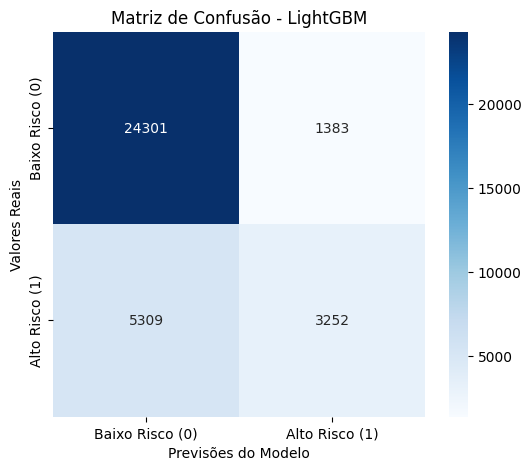

In [14]:
print("Comparando performance:")
print(f"Regressão Logística (Baseline) AUC: {roc_auc_score(y_test, y_proba_logreg):.4f}")
print(f"LightGBM AUC: {roc_auc_score(y_test, y_proba_lgbm):.4f}")
# ^ melhoria de 5.29 pontos percentuais

# analisando matriz de confusao
cm = confusion_matrix(y_test, y_pred_lgbm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Baixo Risco (0)', 'Alto Risco (1)'],
            yticklabels=['Baixo Risco (0)', 'Alto Risco (1)'])
plt.title('Matriz de Confusão - LightGBM')
plt.ylabel('Valores Reais')
plt.xlabel('Previsões do Modelo')
plt.show()

### 6.2 Análise de Importância de Features

A análise de `Feature Importance` do LightGBM é essencial para entender quais variáveis o modelo priorizou em suas decisões, fornecendo *insights* de negócio valiosos.


--- Top 15 Features Mais Importantes ---
                                      Feature  Importance
446                            cat__year_2021          99
449                              cat__month_1          87
460                             cat__month_12          83
450                              cat__month_2          74
17    cat__carrier_name_SkyWest Airlines Inc.          74
447                            cat__year_2022          72
18   cat__carrier_name_Southwest Airlines Co.          72
443                            cat__year_2018          69
448                            cat__year_2023          69
5      cat__carrier_name_Delta Air Lines Inc.          65
439                            cat__year_2014          58
455                              cat__month_7          56
2             cat__carrier_name_Allegiant Air          56
440                            cat__year_2015          54
444                            cat__year_2019          54


/tmp/ipython-input-812347143.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importances_df.head(15), palette="rocket")


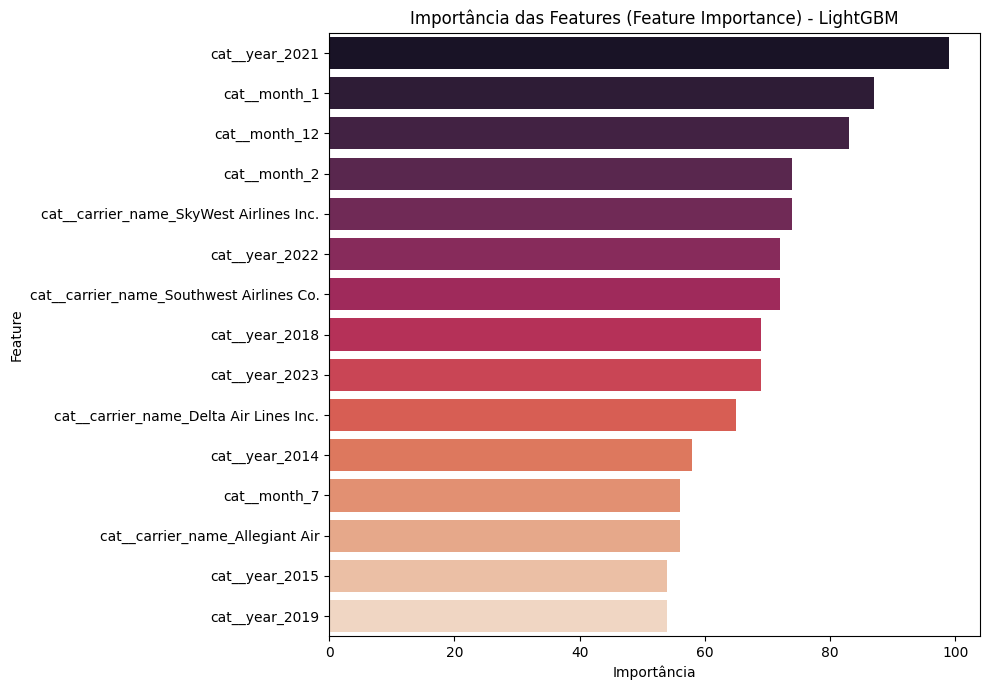

In [15]:
# nomes das features apos OHE
feature_names_ohe = lgbm_pipeline.named_steps['preprocessor'].get_feature_names_out()

# importancia das features
feature_importances = lgbm_pipeline.named_steps['classifier'].feature_importances_

# criacao do dataframe
importances_df = pd.DataFrame({
    'Feature': feature_names_ohe,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
print("\n--- Top 15 Features Mais Importantes ---")
print(importances_df.head(15).to_string())

# grafico de importancia com base no dataframe
plt.figure(figsize=(10, 7))
sns.barplot(x='Importance', y='Feature', data=importances_df.head(15), palette="rocket")
plt.title('Importância das Features (Feature Importance) - LightGBM')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### 6.3 Conclusões de Negócio

#### 1 - Valor Agregado

O modelo LightGBM fornece uma ferramenta preditiva poderosa, alcançando um alto AUC, ou seja, ele distingue bem entre operações de baixo e alto risco, permitindo que companhias aéreas realize ações proativas de mitigação com alta precisão.

A EDA já respondeu parcialmente à questão de companhias aéreas com maior risco, identificando as maiores taxas médias de atraso. JetBlue Airways, American Eagle Airlines e Frontier Airlines Inc são as maiores contribuintes para o problema em questão. Para mais detalhes, refira-se ao gráfico de barras da seção 3.3.

#### 2 - Insights de Negócio e recomendações

Analisando a importancia das features do modelo LGBM, percebe-se que os fatores mais críticos para a previsão de risco são:

1. Fatores sazonais: variaveis relacionadas a ano e mes são definitavemente os preditores mais fortes. Isso confirma uma das perguntas do início: a maior parte do risco de atraso está relacionada a fatores temporais (período pós pandemia e pressão operacional no inverno norte americano). Logo, é importante planejar a logística dessas épocas do ano de forma mais atenta.

2. Identidade da Companhia Aérea: é o segundo grupo de features mais importante. A presença de 'cat__carrier_name_SkyWest Airlines Inc.' e 'cat__carrier_name_Southwest Airlines Co.' no top 7 principais preditores indica que essas companhias são fatores de risco, portanto, seria inteligente alocar mais recursos humanos e logísticos para mitigar os riscos relacionados a elas.

